In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy

In [3]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
engine = create_engine("sqlite:///hawaii_database.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# display classes
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

In [6]:
inspector = inspect(engine)

measurement_columns = inspector.get_columns('measurement')
result = map(lambda col: col['name'], measurement_columns) 
print('--- Measurement ---')
print(list(result))

station_columns = inspector.get_columns('station')
result = map(lambda col: col['name'], station_columns) 
print('--- Station ---')
print(list(result))

--- Measurement ---
['id', 'station', 'date', 'prcp', 'tobs']
--- Station ---
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [7]:
# Calculate one year ago from last date entry
result = session.query(func.max(Measurement.date))[0]
max_date = result[0]
last_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
last_year = last_date - dt.timedelta(days=365)
print('Date Range ' + str(last_year) + ' - ' + str(last_date))

# Perform query to retrive date and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(
                        Measurement.date >= last_year).filter(
                        Measurement.date <= last_date).all()

# Save results in DataFrame. set_index(date)
precipitation_df = pd.DataFrame(results).set_index('date')
precipitation_df = precipitation_df.rename(columns={'prcp': 'precipitation'})
precipitation_df.head(5)

Date Range 2016-08-23 00:00:00 - 2017-08-23 00:00:00


,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [8]:
# Sort by date, remove precipitaiton without a number(NAN)
precipitation_df = precipitation_df.sort_values(by='date').dropna()
precipitation_df.head(5)

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


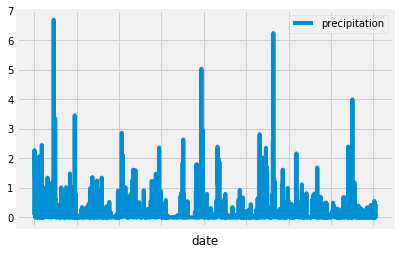

In [9]:
# Plot it
precipitation_df.plot()

In [10]:
# Calculate summary statistics for precipitation scores
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design query to determine number of stations
results = session.query(Station).group_by(Station.id).count()
print('Number of stations ' + str(results))

Number of stations 9


In [12]:
# Design a query to find the most active stations (list stations & observation counts descending)
# Use func.count
results = session.query(
            Measurement.station, func.count(Measurement.station)).group_by(
            Measurement.station).order_by(
            func.count(Measurement.station).desc()).all()
for result in results:
    print(result)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


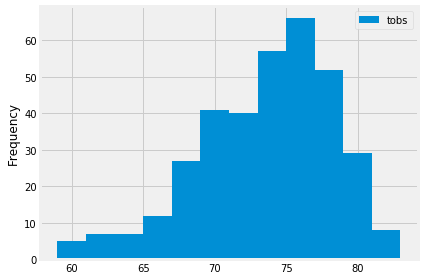

In [13]:
# Filter by the station with highest number of observations
station_name_highest_observations = results[0][0]

results = session.query(Measurement.date, Measurement.tobs).filter(
                        Measurement.date >= last_year).filter(
                        Measurement.date <= last_date).filter(
                        Measurement.station == station_name_highest_observations).all()

# Save results in DataFrame. set_index(date)
tobs_df = pd.DataFrame(results)

# historgram with bins=12
tobs_df.plot.hist(bins=12)
plt.tight_layout()